In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from spectral import *
from spectral import envi
import spectralAdv.atmosphericConversions as atmpy
import os
import pickle
import time
matplotlib.style.use('seaborn-v0_8')
matplotlib.rcParams['figure.figsize'] = (12,6)

pygame 2.1.2 (SDL 2.0.18, Python 3.9.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


Read data and set parameters

In [2]:
notebook_path = os.path.abspath("createDataAVIRIS.ipynb")
fname_spectral_library = os.path.join(os.path.dirname(notebook_path), "clean_ENVI_lib.hdr")
lib = envi.open(fname_spectral_library)
remove_bad_bands = False
remove_noisy_spectra = False
remove_water_bands = False
include_offset = False
plot_sample_atm = True
add_to_current = False
save_only_means = True
include_gain_offset_squared = False
include_gain_squared = True
include_gain = False
save_means_only = True
suffix = str(int(include_offset))
N = 40 # spectra per batch
num_sample_spectra_plots = 2 # the number individual spectra to veiw
num_sample_XY_data = 2 # the number of batches of Xdata,Ydata to view
num_XY_data_to_generate = 1000
print("Number of Spectra: "+str(lib.spectra.shape[0]))
print("Number of Library Bands: "+str(lib.spectra.shape[1]))

Number of Spectra: 1275
Number of Library Bands: 181


Clean data

In [3]:
if remove_bad_bands:
    print("Removing Bad Bands...")
    # Define regions to remove
    # regions = [[0,0.45],[1.3,1.5],[1.75,2], [2.4,3]] # remove the low-signal extremes and water bands
    # regions = [[0,0.4],[1.3,1.5],[1.75,2], [2.479,3]] # remove the low-signal extremes and water bands
    regions = [[0, 0.37], [2.479, 3]]  # remove the low-signal extremes
    for r in regions:
        # get the range of wavelengths for bands to remove
        idx_start = np.argmin(np.abs(np.asarray(lib.bands.centers) - r[0]))
        idx_end = np.argmin(np.abs(np.asarray(lib.bands.centers) - r[1]))
        # remove the bands
        for i in sorted(range(idx_start, idx_end), reverse=True):
            del lib.bands.centers[i]
        # remove the data from the spectra
        lib.spectra = np.delete(lib.spectra, range(idx_start, idx_end), axis=1)

# Compute derivative with fringe bands removed but including water bands
D = np.abs(lib.spectra[:, 10:-45] - lib.spectra[:, 9:-46])
if remove_noisy_spectra:
    print("Removing Noisy Spectra...")
    # remove bands with significant noise spikes, defined by a pair of bands that change by
    # greater than Dthresh
    Dmax = np.max(D, axis=1)
    Dthresh = 0.005
    lib.spectra = np.delete(lib.spectra, np.where(Dmax > Dthresh), axis=0)
    D = np.delete(D, np.where(Dmax > Dthresh), axis=0)
    lib.names = np.delete(lib.names, np.where(Dmax > Dthresh), axis=0)

if remove_water_bands:
    print("Removing Water Bands...")
    # Define regions to remove
    # regions = [[0,0.45],[1.3,1.5],[1.75,2], [2.4,3]] # remove the low-signal extremes and water bands
    regions = [[1.3,1.5],[1.7,2.1]] # remove the low-signal water bands
    for r in regions:
        # get the range of wavelengths for bands to remove
        idx_start = np.argmin(np.abs(np.asarray(lib.bands.centers) - r[0]))
        idx_end = np.argmin(np.abs(np.asarray(lib.bands.centers) - r[1]))
        # remove the bands
        for i in sorted(range(idx_start, idx_end), reverse=True):
            del lib.bands.centers[i]
        # remove the data from the spectra
        lib.spectra = np.delete(lib.spectra, range(idx_start, idx_end), axis=1)

# Compute derivative with fringe and water bands removed
D = np.abs(lib.spectra[:, 10:-45] - lib.spectra[:, 9:-46])

# get the metadata for the cleaned library
nSpec, nBands = lib.spectra.shape
print("Number of Spectra: "+str(lib.spectra.shape[0]))
print("Number of Library Bands: "+str(lib.spectra.shape[1]))

Number of Spectra: 1275
Number of Library Bands: 181


Read atmospheric parameters

In [4]:
# read the MODTRAN atmospheric coefficients
print("Reading atmospheric coefficients...")
ok, atm_coeff = atmpy.read_atmospheric_coefficients()

# read the atmospheric gases library
print("Reading gas library...") 
fname_atm_gas_library = os.path.join(os.path.dirname(notebook_path), "spectralAdv\\atm_gas_dict.pkl")
pkl_file = open(fname_atm_gas_library, 'rb')
atm_dict = pickle.load(pkl_file)
pkl_file.close()

print("Number of Atmospheric library bands: "+str(len(atm_coeff['wl'])))

Reading atmospheric coefficients...
Reading gas library...
Number of Atmospheric library bands: 453


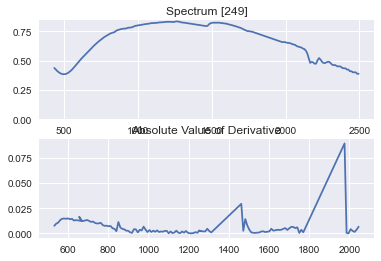

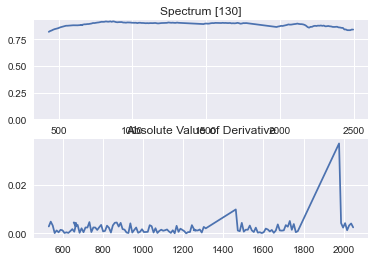

In [5]:
# test - choose a single random spectrum
matplotlib.style.use('seaborn-v0_8')
matplotlib.rcParams['figure.figsize'] = (12,6)
for repeat in range(num_sample_spectra_plots):
    idx = np.random.randint(0, nSpec, 1)
    plt.figure()
    plt.subplot(211)
    plt.plot(lib.bands.centers, lib.spectra[idx, :].flatten())
    plt.title('Spectrum '+str(idx))
    plt.ylim([0, 1.01*np.min([np.max(lib.spectra[idx, :].flatten()),1])])
    plt.subplot(212)
    plt.plot(lib.bands.centers[10:-45], D[idx, :].flatten())
    plt.title('Absolute Value of Derivative')
    plt.show()

In [6]:
print([np.min(atm_coeff['wl']), np.max(atm_coeff['wl'])])
print([np.min(lib.bands.centers)/1000, np.max(lib.bands.centers)/1000])

[0.37864, 2.50542]
[0.433671295, 2.495335938]


In [7]:

# resample the library to the atmospheric wavelengths
print('Resampling to atmospheric coefficients bands')
resample = BandResampler(lib.bands.centers, atm_coeff['wl']*1000)
spec = np.zeros([nSpec, len(atm_coeff['wl'])])
# resample the coefficients
for i in range(nSpec):
    spec[i, :] = resample(lib.spectra[i]);
wl = atm_coeff['wl']

# remove bands where the spectral library has nans (due to greater band coverage by the atmospheric library)
idx_goodbands = np.argwhere(np.isnan(spec[0,:])==False)

wl = wl[idx_goodbands]
np.save(os.path.dirname(notebook_path)+'\\wl.npy', wl)
spec = np.squeeze(spec[:,idx_goodbands])
nSpec, nBands = spec.shape

print("Number of Spectra: "+str(nSpec))
print("Number of Library Bands: "+str(nBands))
print("Number of Atmospheric library bands: "+str(len(atm_coeff['wl'])))

spectral:INFO: No overlap for target band 0 (378.640000 / 3.350000)
spectral:INFO: No overlap for target band 1 (381.990000 / 3.350000)
spectral:INFO: No overlap for target band 2 (385.340000 / 3.355000)
spectral:INFO: No overlap for target band 3 (388.700000 / 3.360000)
spectral:INFO: No overlap for target band 4 (392.060000 / 3.360000)
spectral:INFO: No overlap for target band 5 (395.420000 / 3.360000)
spectral:INFO: No overlap for target band 6 (398.780000 / 3.360000)
spectral:INFO: No overlap for target band 7 (402.140000 / 3.360000)
spectral:INFO: No overlap for target band 8 (405.500000 / 3.365000)
spectral:INFO: No overlap for target band 9 (408.870000 / 3.365000)
spectral:INFO: No overlap for target band 10 (412.230000 / 3.365000)
spectral:INFO: No overlap for target band 11 (415.600000 / 3.370000)
spectral:INFO: No overlap for target band 12 (418.970000 / 3.370000)
spectral:INFO: No overlap for target band 13 (422.340000 / 3.370000)
spectral:INFO: No overlap for target band 14

Resampling to atmospheric coefficients bands
Number of Spectra: 1275
Number of Library Bands: 409
Number of Atmospheric library bands: 453


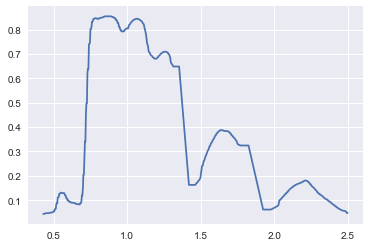

In [8]:
matplotlib.style.use('seaborn-v0_8')
matplotlib.rcParams['figure.figsize'] = (6,4)
plt.plot(wl,spec[0,:]);

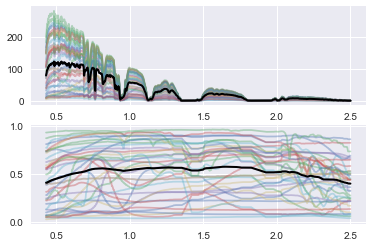

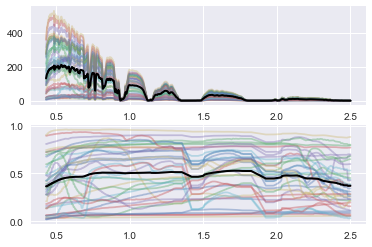

In [9]:
# create X and Y data for example viewing
conversion_type = 'ref_to_rad'
for i in range(num_sample_XY_data):
    # create random selection of Y data (reflectance)
    idx = np.random.randint(0, nSpec, N)
    Yspec = spec[idx,:]
    Yspec[(N-1),:] = np.mean(Yspec[0:(N-2),:],axis=0)

    # get a randomly selected atmopsheric model
    solar_zenith_angle = 5*np.random.randint(1, 17, 1)
    atmospheric_index = np.random.randint(0, 6, 1)
    aerosol_index = np.random.randint(0, 12, 1)
    ok, atm_poly_coeff = atmpy.get_atm_poly_coeff(atm_coeff, conversion_type, solar_zenith_angle[0], atmospheric_index,
                                                  aerosol_index)
    atm_poly_coeff = np.squeeze(atm_poly_coeff[idx_goodbands,:])
    Xspec = np.zeros([N,nBands])

    if include_offset:
        for i in range (N-1):
            Xspec[i] = atm_poly_coeff[:,0]*Yspec[i]**2 + atm_poly_coeff[:,1]*Yspec[i] + atm_poly_coeff[:,2]
    else:
        for i in range (N-1):
            Xspec[i] = atm_poly_coeff[:,0]*Yspec[i]**2 + atm_poly_coeff[:,1]*Yspec[i]
    Xspec[(N-1),:] = np.mean(Xspec[0:(N-2),:],axis=0)
    
    # example plot
    plt.figure()
    plt.subplot(211)
    plt.plot(wl,Xspec.T, alpha=0.4)
    plt.plot(wl,Xspec[(N-1),:].flatten(), color='k', linewidth=2)
    plt.subplot(212)
    plt.plot(wl,Yspec.T, alpha=0.4)
    plt.plot(wl,Yspec[(N-1),:].flatten(), color='k', linewidth=2)
    plt.show()

In [10]:
if save_means_only == False:
    # create X and Y data
    Xdata = np.zeros([num_XY_data_to_generate, N, nBands])
    Ydata = np.zeros([num_XY_data_to_generate, N, nBands])
    start = time.time()
    for i in range(num_XY_data_to_generate):
        if (i % 500 == 0):
            print('Generating data batch: '+str(i)+' of '+str(num_XY_data_to_generate))
        # create a random subset for Y data (reflectance)
        idx = np.random.randint(0, nSpec, N)
        Yspec = spec[idx,:]
        Yspec[(N-1),:] = np.nanmean(Yspec[0:(N-2),:],axis=0)

        # get a randomly selected atmopsheric model
        solar_zenith_angle = 5*np.random.randint(1, 10, 1)
        atmospheric_index = np.random.randint(0, 6, 1)
        aerosol_index = np.random.randint(0, 12, 1)
        ok, atm_poly_coeff = atmpy.get_atm_poly_coeff(atm_coeff, conversion_type, solar_zenith_angle[0], atmospheric_index,
                                                    aerosol_index)
        atm_poly_coeff = np.squeeze(atm_poly_coeff[idx_goodbands,:])
        Xspec = np.zeros([N,nBands])
        if include_offset:
            for spec_idx in range (N-1):
                # include gain, offset, quadratic
                Xspec[spec_idx] = atm_poly_coeff[:,0]*Yspec[spec_idx]**2 + atm_poly_coeff[:,1]*Yspec[spec_idx] + atm_poly_coeff[:,2]
        else:
            for spec_idx in range (N-1):
                # include gain and quadratice (no offset)
                Xspec[spec_idx] = atm_poly_coeff[:,0]*Yspec[spec_idx]**2 + atm_poly_coeff[:,1]*Yspec[spec_idx]
        Xspec[(N-1),:] = np.nanmean(Xspec[0:(N-2),:],axis=0)

        Xdata[i,:,:] = Xspec
        Ydata[i,:,:] = Yspec

    if add_to_current:
        if os.path.exists('Xdata'+suffix+'.npy'):
            print('Reading prior data.')
            Xdata_from_file = np.load(os.path.dirname(notebook_path)+'\\Xdata'+suffix+'.npy')
            Ydata_from_file = np.load(os.path.dirname(notebook_path)+'\\Ydata'+suffix+'.npy')
            print('Merging data.')
            Xdata = np.vstack((Xdata_from_file, Xdata))
            Ydata = np.vstack((Ydata_from_file, Ydata))

    print('Saving data.')
    np.save(os.path.dirname(notebook_path)+'\\Xdata'+suffix+'_small.npy', Xdata)
    np.save(os.path.dirname(notebook_path)+'\\Ydata'+suffix+'_small.npy', Ydata)

    end = time.time()
    print("Elapsed time to generate data: "+str(end - start)+" seconds.")
    print("Number of observations generated: "+str(num_XY_data_to_generate))
    print("Total number of observations: "+str(Xdata.shape[0]))

In [11]:
if save_means_only == True:
    # create X and Y data
    Xdata = np.zeros([num_XY_data_to_generate, N, nBands])
    Ydata = np.zeros([num_XY_data_to_generate, N, nBands])
    start = time.time()
    for i in range(num_XY_data_to_generate):
        if (i % 500 == 0):
            print('Generating data batch: '+str(i)+' of '+str(num_XY_data_to_generate))
        # create a random subset for Y data (reflectance)
        idx = np.random.randint(0, nSpec, N)
        Yspec = spec[idx,:]
        YspecMean = np.mean(Yspec, axis=0)

        # get a randomly selected atmopsheric model
        solar_zenith_angle = 5*np.random.randint(1, 10, 1)
        atmospheric_index = np.random.randint(0, 6, 1)
        aerosol_index = np.random.randint(0, 12, 1)
        ok, atm_poly_coeff = atmpy.get_atm_poly_coeff(atm_coeff, conversion_type, solar_zenith_angle[0], atmospheric_index,
                                                    aerosol_index)
        atm_poly_coeff = np.squeeze(atm_poly_coeff[idx_goodbands,:])
        Xspec = np.zeros([N,nBands])
        if include_gain_offset_squared:
            suffix = 'OGS'
            for spec_idx in range (N-1):
                # include gain, offset, quadratic
                Xspec[spec_idx] = atm_poly_coeff[:,0]*Yspec[spec_idx]**2 + atm_poly_coeff[:,1]*Yspec[spec_idx] + atm_poly_coeff[:,2]
        if include_gain_squared:
            suffix = 'GS'
            for spec_idx in range (N-1):
                # include gain and quadratice (no offset)
                Xspec[spec_idx] = atm_poly_coeff[:,0]*Yspec[spec_idx]**2 + atm_poly_coeff[:,1]*Yspec[spec_idx]
        if include_gain:
            suffix = 'G'
            for spec_idx in range (N-1):
                # include gain and quadratice (no offset)
                Xspec[spec_idx] = atm_poly_coeff[:,1]*Yspec[spec_idx]
        XspecMean = np.mean(Xspec,axis=0)

        Xspec[0, :] = XspecMean
        Xdata[i, :, :] = Xspec
        Yspec[0,:] = YspecMean
        Ydata[i, :, :] = Yspec

    """
    print('Ensuring that the number of bands is even.')
    if np.mod(Xspec.shape[1],2)==1:
        Xdata = Xdata[:,1:nBands]
        Ydata = Ydata[:,1:nBands]
        wl = wl[1:nBands]
    """

    np.save('wl.npy', wl)
    if add_to_current:
        if os.path.exists('Xdata_Means'+suffix+'.npy'):
            print('Reading prior data.')
            Xdata_from_file = np.load(os.path.dirname(notebook_path)+'\\Xdata_Means'+suffix+'.npy')
            Ydata_from_file = np.load(os.path.dirname(notebook_path)+'\\Ydata_Means'+suffix+'.npy')
            print('Merging data.')
            Xdata = np.vstack((Xdata_from_file, Xdata))
            Ydata = np.vstack((Ydata_from_file, Ydata))

        print('Saving data.')
        np.save(os.path.dirname(notebook_path)+'\\Xdata_Means' + suffix + '.npy', Xdata)
        np.save(os.path.dirname(notebook_path)+'\\Ydata_Means' + suffix + '.npy', Ydata)

    else:
        print('Saving data.')
        np.save(os.path.dirname(notebook_path)+'\\Xdata_Means' + suffix + '.npy', Xdata)
        np.save(os.path.dirname(notebook_path)+'\\Ydata_Means' + suffix + '.npy', Ydata)

    end = time.time()
    print("Elapsed time to generate data: "+str(end - start)+" seconds.")
    print("Number of observations generated: "+str(num_XY_data_to_generate))
    print("Total number of observations: "+str(Xdata.shape[0]))
    print('pause')

Generating data batch: 0 of 1000
Generating data batch: 500 of 1000
Saving data.
Elapsed time to generate data: 2.7330682277679443 seconds.
Number of observations generated: 1000
Total number of observations: 1000
pause
